<a href="https://colab.research.google.com/github/sam9092/NCYU-Club-Guide-by-RAG/blob/main/%E5%98%89%E5%A4%A7%E8%B3%87%E5%B7%A51130328%E5%91%82%E6%99%BA%E7%BF%94_%E6%89%93%E9%80%A0_RAG_%E7%B3%BB%E7%B5%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. 讀入需要的套件

裝爬蟲所需的套件

In [ ]:
!pip install -qU requests
!pip install -qU bs4
!pip install -qU pandas
!pip install -qU chardet
!pip install -qU tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 87.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


這裡主要用 LangChain, 這可以說整合各式 LLM 功能的方便套件。

In [ ]:
!pip install -qU nltk

In [ ]:
!pip install -qU langchain langchain-community sentence-transformers faiss-cpu gradio openai pypdf python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# 靜態生成網頁用
import requests

# html解析用
from bs4 import BeautifulSoup

# 數據分析用
import pandas as pd
import re

# 輔助工具
from tqdm import tqdm
import csv
import os

In [ ]:
from langchain_community.document_loaders import TextLoader, PyPDFLoader, UnstructuredWordDocumentLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

In [ ]:
from openai import OpenAI
import gradio as gr

## 2.開始爬蟲

*   設定 嘉義大學的社團介紹頁
*   輸出CSV和TXT的檔名
*   資料儲存的變數

In [ ]:
mainPage = "https://www.ncyuactivity.com/club?page="
outputCSV = "ncyu_club_dataset.csv"
outputTXT = "ncyu_club_dataset.txt"

floder="club_html"
# 存放所有社團資料
club_data = []

要抓哪些資料

In [ ]:
# csv的欄位名
fieldnames = ["社團名稱", "社團類型", "社團介紹", "Facebook", "Instagram", "學校介紹頁網址"]

# 建立資料夾（如果不存在）
os.makedirs(floder, exist_ok=True)

開始爬共18頁的社團官網，與社團的詳細介紹

In [ ]:
# 爬取第1頁到第18頁，並加入 tqdm 進度條
for page in tqdm(range(1, 19), desc="📄 抓取頁面進度"):
    url = mainPage+str(page)
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
    }
    res = requests.get(url, headers=headers)
    soup = BeautifulSoup(res.text, "html.parser")

    clubs = soup.select("div.course-item")

    for club in clubs:
        name_tag = club.select_one("h3.course-title a")
        name = name_tag.text.strip()
        detail_url = name_tag["href"]
        club_type = club.select_one("span.course-label-text").text.strip()
        description = club.select_one("div.course-meta p").text.strip()

        fb,ig = "",""

        detail_res = requests.get(detail_url)
        detail_html = detail_res.text
        detail_soup = BeautifulSoup(detail_html, "html.parser")

        # 從 URL 中擷取 ID 作為檔名
        match = re.search(r'/(\d+)$', detail_url)
        if match:
            file_id = match.group(1)
            html_path = os.path.join(floder, f"{file_id}.html")
            with open(html_path, "w", encoding="utf-8") as f:
                f.write(detail_html)

        paragraphs = detail_soup.select("div.blog-content p p")
        for p in paragraphs:
            text = p.text.strip()
            if "facebook.com" in text.lower():
                fb = text
            elif "instagram.com" in text.lower():
                ig = text

        row = {
            "社團名稱": name,
            "社團類型": club_type,
            "社團介紹": " ".join(description.split()),
            "Facebook": fb,
            "Instagram": ig,
            "學校介紹頁網址": detail_url
        }
        club_data.append(row)
print(f"\n📁 全部社團的學校介紹頁 已儲存在 club_html 資料夾內")

📄 抓取頁面進度: 100%|██████████| 18/18 [01:11<00:00,  3.97s/it]


📁 全部社團的學校介紹頁 已儲存在 club_html 資料夾內


把結果放到CSV確認，並把每個html放入指定的資料夾內保存

In [ ]:
# 寫入 CSV
with open(outputCSV, "w", newline="", encoding="utf-8-sig") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(club_data)

print(f"📝 所有資料已儲存到 {outputCSV}，共 {len(club_data)} 筆社團資料")

📝 所有資料已儲存到 ncyu_club_dataset.csv，共 105 筆社團資料


為了建立向量資料庫，把資料用格式化整理好並匯成txt

In [ ]:
# 寫入 TXT
with open(outputTXT, "w", encoding="utf-8-sig") as f:
    for row in club_data:
        f.write(f"社團名稱：{row['社團名稱']}\n")
        f.write(f"社團類型：{row['社團類型']}\n")
        f.write(f"社團介紹：{row['社團介紹']}\n")
        f.write(f"Facebook：{row['Facebook']}\n")
        f.write(f"Instagram：{row['Instagram']}\n")
        f.write(f"學校介紹頁網址：{row['學校介紹頁網址']}\n")
        f.write("\n")

print(f"📝 社團資料已格式化寫入 {outputTXT}")

📝 社團資料已格式化寫入 ncyu_club_dataset.txt


## 3. 自訂 E5 embedding 類別

In [ ]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

## 4. 載入文件

直接讀取前面建立的txt

In [ ]:
folder_path = "/content/"
documents = []
for file in os.listdir(folder_path):
    path = os.path.join(folder_path, file)
    if file.endswith(".txt"):
        loader = TextLoader(path)
    else:
        continue
    documents.extend(loader.load())

## 5. 建立向量資料庫

In [ ]:
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
split_docs = splitter.split_documents(documents)

In [ ]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
vectorstore = FAISS.from_documents(split_docs, embedding_model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/498k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

## 6. 儲存向量資料庫

In [ ]:
vectorstore.save_local("faiss_db")

In [ ]:
!zip -r faiss_db.zip faiss_db

  adding: faiss_db/ (stored 0%)
  adding: faiss_db/index.faiss (deflated 8%)
  adding: faiss_db/index.pkl (deflated 70%)


In [ ]:
print("✅ 壓縮好的向量資料庫已儲存為 'faiss_db.zip'，請下載此檔案備份。")

✅ 壓縮好的向量資料庫已儲存為 'faiss_db.zip'，請下載此檔案備份。


## 7. 載入 `faiss_db`

In [ ]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
db = FAISS.load_local("faiss_db", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()

## 8. 設定好我們要的 LLM

In [ ]:
import os
from google.colab import userdata

如之前, 我們會用 OpenAI API。這裡使用 Groq 服務, 可改成你要的服務。

In [ ]:
api_key = userdata.get('Groq')

In [ ]:
os.environ["OPENAI_API_KEY"] = api_key

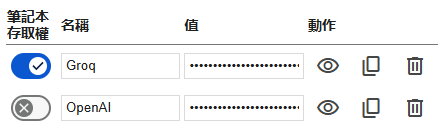

這裡的模型和 `base_url` 是用 Groq, 如果用其他服務請自行修改。

In [ ]:
model = "llama3-70b-8192"
base_url="https://api.groq.com/openai/v1"

In [ ]:
client = OpenAI(
    base_url=base_url # 使用 OpenAI 本身不需要這段
)

## 9. `prompt` 設計

In [ ]:
system_prompt = "請用台灣習慣的中文回應。你是嘉義大學的社團博覽會  AI公關，請根據資料來回應學生的問題。請親切、簡潔並附帶具體建議。"

prompt_template = """
根據下列資料回答問題：
{retrieved_chunks}

使用者的問題是：{question}

請根據資料內容回覆，若資料不足請告訴同學可以請教學務處課外活動組的老師。
"""

## 10. 使用 RAG 來回應

搜尋與使用者問題相關的資訊，根據我們的 prompt 樣版去讓 LLM 回應。

In [ ]:
chat_history = []

def chat_with_rag(user_input):
    global chat_history
    # 取回相關資料
    docs = retriever.get_relevant_documents(user_input)
    retrieved_chunks = "\n\n".join([doc.page_content for doc in docs])

    # 將自定 prompt 套入格式
    final_prompt = prompt_template.format(retrieved_chunks=retrieved_chunks, question=user_input)

    # 呼叫 OpenAI API
    response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": final_prompt},
    ]
    )
    answer = response.choices[0].message.content

    chat_history.append((user_input, answer))
    return answer

## 11. 用 Gradio 打造 Web App

In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("# 嘉義大學 社團博覽會公關")
    chatbot = gr.Chatbot()
    msg = gr.Textbox(placeholder="請輸入你的問題...")

    def respond(message, chat_history_local):
        response = chat_with_rag(message)
        chat_history_local.append((message, response))
        return "", chat_history_local

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch(debug=True)

<ipython-input-28-1d53a2c84091>:3: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://52276da03fbdc2b33b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


<ipython-input-27-ef9176c6ed60>:6: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(user_input)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://52276da03fbdc2b33b.gradio.live


## 結果展示

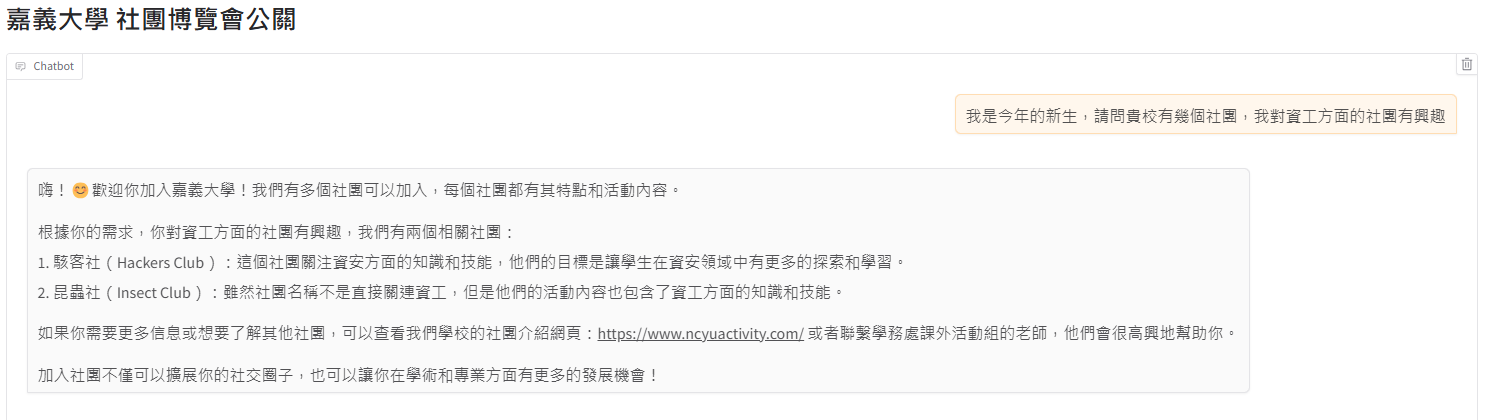

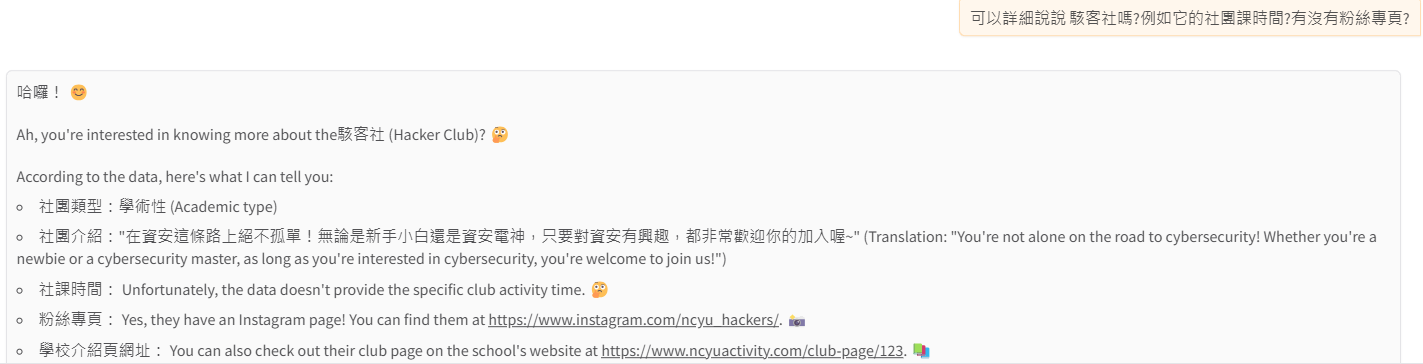